In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pyrivet import rivet
from sklearn.datasets import fetch_openml
from sklearn.metrics import pairwise_distances, adjusted_rand_score
from sklearn.decomposition import PCA
from pyDowker.DowkerComplex import DowkerComplex
from pyDowker.TwoParameterUtils import discretize_graded_rank, graded_rank_at_value
import seaborn as sns
import pickle
import persistable
from tqdm.auto import tqdm
from joblib import Parallel, delayed



In [2]:
gene = pd.read_csv(
    "./Gene_cancer/data.csv", sep=",", index_col=0
)  # , header = True)
headers_gene = gene.columns.values

labels = pd.read_csv("./Gene_cancer/labels.csv", sep=",", index_col=0)
sorted_index = labels.sort_values('Class').index

print(gene.shape, labels.shape)
gene

(801, 20531) (801, 1)


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [4]:
sorted_index = labels.sort_values("Class").index

X = gene.loc[sorted_index].to_numpy()
y = labels.loc[sorted_index].Class.to_numpy()

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_num = le.fit_transform(y)

D = pairwise_distances(X, metric='euclidean', n_jobs=-1)

knn_mat = np.argsort(np.argsort(D))

In [5]:
from sklearn.neighbors import BallTree





def create_mcknn_bifiltered_graph(X, m_max=5, k_max = 10, normalize = False):
    """
    
    creates a rivet m-common-k-nearest-neighbor bifiltered graph storing the filtered simpicial complex.
        Uses recursive algorithm with nummpy arrays, fast for small datasets but worse runtime and memory complexity.
    

    Parameters
    ----------
    max_dimension : int
        Dimension of the skeleton to compute.
    m_max : int, optional
        Maximal number of common neighbors to include, by default 5
    k_max : int, optional
        Maximal number of nearest neighbors to include, by default 10
    normalize : bool, optional
        whether to normalize the number of neighbors to the interval [0,1], by default False

    Returns
    -------
    rivet.Bifiltration
        A RIVET-compatible bifiltration listing simplices and their bidegrees of appearance.
    """
    

    num_points=len(X)


    simplices = []
    appearances = []

    bt = BallTree(X, metric = 'euclidean')
    _,LAMBDA = bt.query(X, k=k_max)

    def compute_subree_appearances(k):
        local_simplices = []
        local_appearances = []
        local_simplices.append([k])
        local_appearances.append([(i-1,i) for i in range (1,m_max+1)])
        for j in range(k+1, num_points):
            this_appearances = []
            #j_neighbors = bt.query(X[[j]], k = k_max)[1][0]
            common_neighbors, k_ind, j_ind = np.intersect1d(*LAMBDA[[k,j]], assume_unique=True, return_indices=True)
            val = 0
            for i in range(1,len(common_neighbors)):
                prev_val = val
                val = np.sum(np.logical_and(k_ind<=i, j_ind<=i))
                if val > prev_val:
                    this_appearances.append((i,val))
            
            local_simplices.append([k,j])
            local_appearances.append(this_appearances)

        return [local_simplices, local_appearances]
    
    results = Parallel(n_jobs=-1)(delayed(compute_subree_appearances)(k) for k in range(num_points-1,-1,-1))
    #results = [compute_subree_appearances(k) for k in range(num_points-1,-1,-1)]

    for i in range(len(results)):
        for s in results[i][0]:
            simplices.append(s)
        for a in results[i][1]:
            appearances.append(a)

    bf = rivet.Bifiltration(
        x_label = "k nearest neighbors",
        y_label = "m common neighbors",
        simplices = simplices,
        appearances = appearances,
        yreverse = True
    )

    return bf


bifi = create_mcknn_bifiltered_graph(X, k_max = 100, m_max = 64)

In [6]:
bifi.appearances

[[(0, 1),
  (1, 2),
  (2, 3),
  (3, 4),
  (4, 5),
  (5, 6),
  (6, 7),
  (7, 8),
  (8, 9),
  (9, 10),
  (10, 11),
  (11, 12),
  (12, 13),
  (13, 14),
  (14, 15),
  (15, 16),
  (16, 17),
  (17, 18),
  (18, 19),
  (19, 20),
  (20, 21),
  (21, 22),
  (22, 23),
  (23, 24),
  (24, 25),
  (25, 26),
  (26, 27),
  (27, 28),
  (28, 29),
  (29, 30),
  (30, 31),
  (31, 32),
  (32, 33),
  (33, 34),
  (34, 35),
  (35, 36),
  (36, 37),
  (37, 38),
  (38, 39),
  (39, 40),
  (40, 41),
  (41, 42),
  (42, 43),
  (43, 44),
  (44, 45),
  (45, 46),
  (46, 47),
  (47, 48),
  (48, 49),
  (49, 50),
  (50, 51),
  (51, 52),
  (52, 53),
  (53, 54),
  (54, 55),
  (55, 56),
  (56, 57),
  (57, 58),
  (58, 59),
  (59, 60),
  (60, 61),
  (61, 62),
  (62, 63),
  (63, 64)],
 [(0, 1),
  (1, 2),
  (2, 3),
  (3, 4),
  (4, 5),
  (5, 6),
  (6, 7),
  (7, 8),
  (8, 9),
  (9, 10),
  (10, 11),
  (11, 12),
  (12, 13),
  (13, 14),
  (14, 15),
  (15, 16),
  (16, 17),
  (17, 18),
  (18, 19),
  (19, 20),
  (20, 21),
  (21, 22),
  (22

In [39]:
%%time
m_max = 64
LAMBDA = np.where(knn_mat<100, knn_mat, np.inf)

dowker = DowkerComplex(LAMBDA, max_filtration=100)

#bifi = dowker.create_rivet_bifiltration(max_dimension=1, m_max=m_max)
#bifi = create_mcknn_bifiltered_graph(X, k_max=100, m_max=64)
betti = rivet.betti(bifi,homology=0,x=m_max,y=m_max)

output = open('output/Gene_cancer_betti.pkl'.format(m_max), 'wb')
pickle.dump(betti, output)
output.close()

  0%|          | 0/801 [00:00<?, ?it/s]

Error occurred, leaving RIVET working directory intact: /tmp/rivet-3070327-1723714871.5148342


KeyboardInterrupt: 

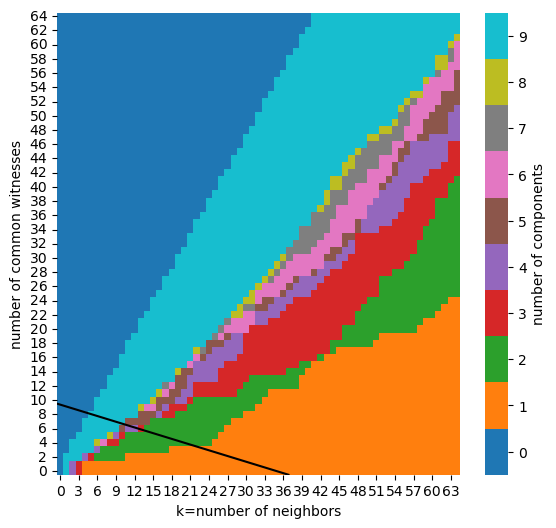

In [5]:
x_grid = np.linspace(0,100,m_max+1)
y_grid = np.linspace(-m_max,0,m_max+1)


gridbetti = discretize_graded_rank(betti,x_grid,y_grid)

v_min = None
v_max = 10
#lnorm = LogNorm(vmin=v_min,vmax=v_max)
colormap = sns.color_palette("binary", as_cmap=True)

f,ax = plt.subplots(1,1,figsize=(6.5,6))
sns.heatmap(gridbetti[:][::-1],
            rasterized=True,
            linewidths=0,
            ax=ax,
            annot=False,
            #yticklabels=-y_grid,
            #xticklabels=np.round(x_grid,2),
            cmap=plt.cm.tab10,
            vmin = -0.5,
            vmax=9.5,
           cbar_kws={'ticks':np.arange(11), 'label':'number of components'})
ax.invert_yaxis()


ax.set_ylabel("number of common witnesses")
ax.set_xlabel("k=number of neighbors")
plt.grid(False)
y_offset = 10
angle = (-15/180) * np.pi
plt.axline((0,y_offset), slope = np.tan(angle), c='k')
#plt.savefig("output/gene_cancer_neighbors_H0_custer.pdf".format(m_max), bbox_inches='tight', pad_inches=0)
plt.show()

[196.79998474   8.00003815]
529.9001759364883


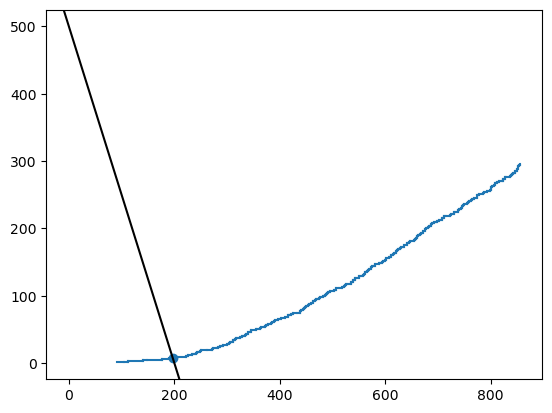

In [26]:
bidegs = np.array(bifi.appearances[2])
y_offset = 500
angle = -np.arctan(2.5)

for i in range(len(bidegs)-1):
    plt.plot((bidegs[i,0],bidegs[i+1,0]),(bidegs[i,1],bidegs[i,1]), color='tab:blue')
    plt.plot((bidegs[i+1,0],bidegs[i+1,0]),(bidegs[i,1],bidegs[i+1,1]), color='tab:blue')

plt.axline((0,y_offset), slope = np.tan(angle), c='k')

vec = np.array([np.cos(angle),np.sin(angle)])

y_low = 0
y_high = 18
err = 1e-4

i=0
while y_high-y_low > err:
    y_mid = (y_high+y_low)/2
    t = (y_mid-y_offset)/vec[1]
    x_val = t*vec[0]
    if x_val <= bidegs[int(y_mid)][0]:
        y_high = y_mid
    else:
        y_low = y_mid

    #plt.text(t*vec[0],y_offset+t*vec[1], s="{}".format(i))
    i=i+1
print(np.array([0,y_offset]+t*vec))
print(t)
plt.scatter(t*vec[0],y_offset+t*vec[1])

plt.show()


In [8]:
bidegs

array([[15,  1],
       [18,  2],
       [22,  3],
       [24,  4],
       [26,  6],
       [31,  7],
       [32,  8],
       [33, 10],
       [34, 11],
       [36, 12],
       [38, 14],
       [39, 15],
       [42, 17],
       [43, 18],
       [44, 19],
       [45, 20],
       [47, 21],
       [48, 22],
       [49, 23],
       [50, 24],
       [52, 25],
       [53, 26],
       [55, 28],
       [56, 29],
       [58, 31],
       [61, 33],
       [62, 35],
       [63, 36],
       [65, 38],
       [66, 39],
       [67, 40],
       [68, 41],
       [70, 43],
       [71, 45],
       [72, 47],
       [73, 49],
       [75, 51],
       [76, 52],
       [77, 53],
       [78, 54],
       [79, 55],
       [80, 57],
       [81, 58]])

In [9]:
def slice_filtration_value_from_bidegs(y_offset, angle, bidegs, err = 1e-4):
    vec = np.array([np.cos(angle),np.sin(angle)])

    y_low = 0
    y_high = np.max(bidegs[:,1])


    i=0
    while y_high-y_low > err:
        y_mid = (y_high+y_low)/2
        t = (y_mid-y_offset)/vec[1]
        x_val = t*vec[0]
        if y_mid>= len(bidegs):
            return np.inf
        if x_val <= bidegs[int(y_mid)][0]:
            y_high = y_mid
        else:
            y_low = y_mid

        #plt.text(t*vec[0],y_offset+t*vec[1], s="{}".format(i))
        i=i+1
    return t

def filtered_graph_from_simplex_tree(tree):
    vertex_values = np.zeros(tree.num_vertices())
    edges = []
    edge_values = []
    for s,val in tree.get_filtration():
        if len(s)==1:
            vertex_values[s[0]]=val
        elif len(s)==2:
            edges.append(s)
            edge_values.append(val)

    FG = persistable.FilteredGraph(np.array(vertex_values),
                                np.array(edges),
                                np.array(edge_values))
    return FG

def filtered_graph_from_bifiltration(bifi, y_offset, angle):
    vertices = np.array([s for s in bifi.simplices if len(s)==1])
    vertex_values = np.zeros(len(vertices))
    edges = []
    edge_values = []
    for i in range(len(bifi.simplices)):
        if len(bifi.appearances[i])>0:
            bidegs = np.array(bifi.appearances[i])
            val = slice_filtration_value_from_bidegs(y_offset,angle,bidegs)
            if len(bifi.simplices[i])==1:
                vertex_values[bifi.simplices[i][0]]=val
            elif len(bifi.simplices[i])==2:
                edges.append(bifi.simplices[i])
                edge_values.append(val)
    FG = persistable.FilteredGraph(np.array(vertex_values),
                               np.array(edges),
                               np.array(edge_values))
    return FG
slice_filtration_value_from_bidegs(y_offset,angle,bidegs)

inf

In [10]:
FG = filtered_graph_from_bifiltration(bifi,y_offset,angle)
cluster_labels = FG.persistence_based_flattening(n_clusters=5)

0.9972347066167291
0.9924697364526301


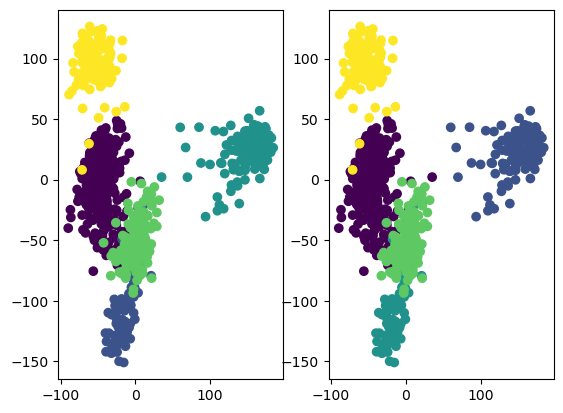

In [11]:
from sklearn import metrics
print(metrics.rand_score(y_num, cluster_labels))
print(metrics.adjusted_rand_score(y_num, cluster_labels))
pca = PCA(n_components = 2)
emb = pca.fit_transform(X)
f,ax = plt.subplots(1,2)
ax[0].scatter(emb[:,0],emb[:,1], c=y_num)
ax[1].scatter(emb[:,0],emb[:,1], c=cluster_labels)
plt.show()

### Synthetic data from hdbscan

In [12]:
from urllib.request import urlopen
from io import BytesIO

url = "https://github.com/scikit-learn-contrib/hdbscan/blob/4052692af994610adc9f72486a47c905dd527c94/notebooks/clusterable_data.npy?raw=true"
f = urlopen(url)
rf = f.read()
data = np.load(BytesIO(rf))

In [13]:
D = pairwise_distances(data, metric='euclidean', n_jobs=-1)

knn_mat = np.argsort(np.argsort(D))

In [14]:
%%time
m_max = 32
LAMBDA = D#np.where(knn_mat<64, knn_mat, np.inf)

dowker = DowkerComplex(LAMBDA.T, max_filtration=0.1)

bifi = dowker.create_rivet_bifiltration(max_dimension=1, m_max=m_max)
betti = rivet.betti(bifi,homology=0,x=m_max,y=m_max)

CPU times: user 5min 47s, sys: 2.57 s, total: 5min 49s
Wall time: 15min 26s


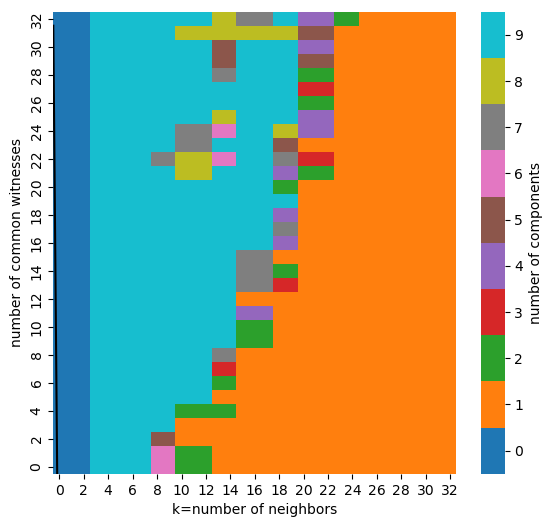

In [15]:
x_grid = np.linspace(0,0.3,m_max+1)
y_grid = np.linspace(-m_max,0,m_max+1)


gridbetti = discretize_graded_rank(betti,x_grid,y_grid)

v_min = None
v_max = 10
#lnorm = LogNorm(vmin=v_min,vmax=v_max)
colormap = sns.color_palette("binary", as_cmap=True)

f,ax = plt.subplots(1,1,figsize=(6.5,6))
sns.heatmap(gridbetti[:][::-1],
            rasterized=True,
            linewidths=0,
            ax=ax,
            annot=False,
            #yticklabels=-y_grid,
            #xticklabels=np.round(x_grid,2),
            cmap=plt.cm.tab10,
            vmin = -0.5,
            vmax=9.5,
           cbar_kws={'ticks':np.arange(11), 'label':'number of components'})
ax.invert_yaxis()


ax.set_ylabel("number of common witnesses")
ax.set_xlabel("k=number of neighbors")
plt.grid(False)
y_offset = 32
angle = -np.arctan(100)
plt.axline((0,y_offset), slope = np.tan(angle), c='k')
#plt.savefig("output/gene_cancer_neighbors_H0_custer.pdf".format(m_max), bbox_inches='tight', pad_inches=0)
plt.show()

/tmp/ipykernel_647043/624192384.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[i].scatter(data[:,0],data[:,1], c=[noise_color if x==-1 else scalarMap.to_rgba(x) for x in cluster_labels], alpha = 0.3, cmap = 'tab10')


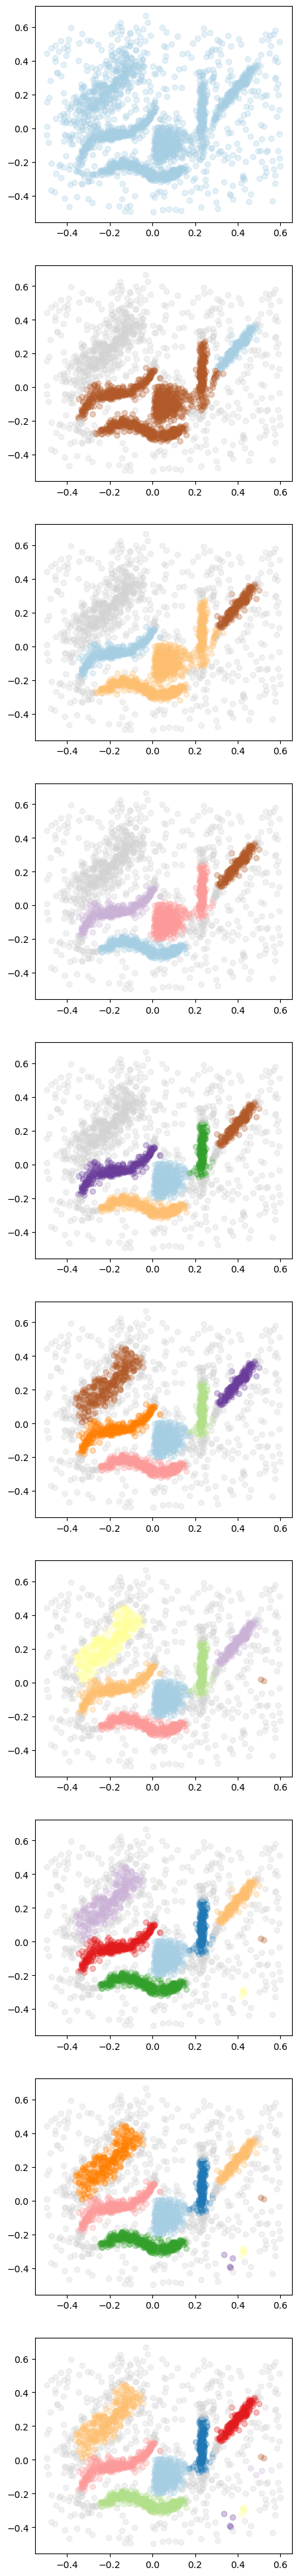

In [16]:


FG = filtered_graph_from_bifiltration(bifi,y_offset,angle)

Max_num_clusters = 10
f,ax = plt.subplots(Max_num_clusters,1, figsize = (5,5*Max_num_clusters))
for i in range(len(ax)):
    cluster_labels = FG.persistence_based_flattening(n_clusters=i+1,flattening_mode='conservative',keep_low_persistence_clusters=False)
    cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=np.amax(cluster_labels))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='Paired')
    noise_color = (211/255, 211/255, 211/255, 1) # light grey
    ax[i].scatter(data[:,0],data[:,1], c=[noise_color if x==-1 else scalarMap.to_rgba(x) for x in cluster_labels], alpha = 0.3, cmap = 'tab10')

plt.show()

/tmp/ipykernel_90402/998343606.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(data[:,0],data[:,1], c=[noise_color if x==-1 else scalarMap.to_rgba(x) for x in cluster_labels], alpha = 0.3, cmap = 'tab10')


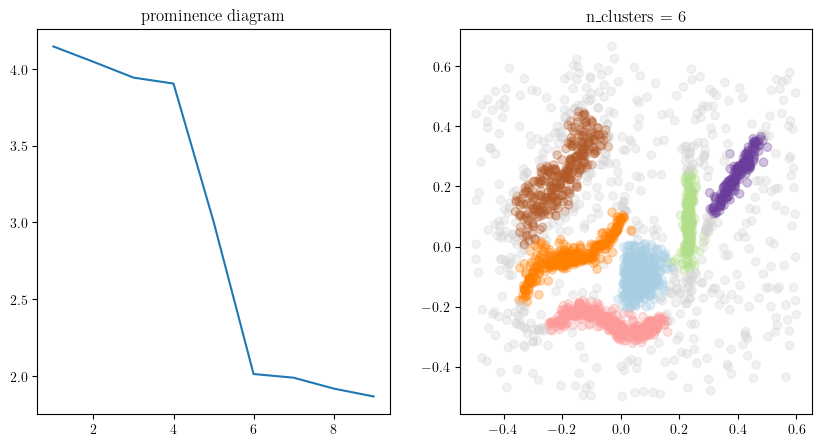

In [ ]:
f,ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(FG.prominence_diagram()[:10])
ax[0].set_title('prominence diagram')

cluster_labels = FG.persistence_based_flattening(n_clusters=6,flattening_mode='conservative',keep_low_persistence_clusters=False)
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=np.amax(cluster_labels))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='Paired')
noise_color = (211/255, 211/255, 211/255, 1) # light grey
ax[1].scatter(data[:,0],data[:,1], c=[noise_color if x==-1 else scalarMap.to_rgba(x) for x in cluster_labels], alpha = 0.3, cmap = 'tab10')
ax[1].set_title('n_clusters = 6')
plt.show()

#### MNIST

In [10]:
mnist = fetch_openml("MNIST_784")
raw_mnist = mnist.data.astype(np.float32)

In [11]:
from sklearn.model_selection import train_test_split
X_1, X_2, Y_1, Y_2 = train_test_split(raw_mnist, mnist.target.astype(np.float32), stratify=mnist.target.astype(np.float32), test_size=0.95)
print(len(X_1))

3500


In [ ]:
D = pairwise_distances(raw_mnist, metric='cosine', n_jobs=-1)
print('distances done')
knn_mat = np.argsort(np.argsort(D))
m_max = 20
LAMBDA = np.where(knn_mat<64, knn_mat, np.inf)
dowker = DowkerComplex(LAMBDA.T, max_filtration=20)

distances done


In [12]:
#bifi = dowker.create_rivet_bifiltration(max_dimension=1, m_max=m_max)
bifi = create_mcknn_bifiltered_graph(X_1,m_max=512, k_max=1500)

In [14]:
bifi.appearances[2]

[(92, 1),
 (104, 2),
 (113, 3),
 (141, 4),
 (148, 5),
 (177, 6),
 (189, 7),
 (195, 8),
 (205, 9),
 (222, 10),
 (225, 11),
 (226, 12),
 (234, 13),
 (238, 14),
 (241, 15),
 (242, 16),
 (244, 17),
 (248, 18),
 (251, 19),
 (261, 20),
 (272, 21),
 (274, 22),
 (279, 23),
 (282, 24),
 (286, 25),
 (291, 26),
 (292, 27),
 (299, 29),
 (303, 30),
 (306, 31),
 (307, 32),
 (311, 33),
 (312, 34),
 (314, 35),
 (315, 36),
 (316, 37),
 (318, 38),
 (325, 39),
 (328, 40),
 (331, 41),
 (334, 42),
 (336, 43),
 (337, 44),
 (339, 46),
 (343, 47),
 (345, 48),
 (346, 49),
 (354, 50),
 (357, 51),
 (362, 52),
 (365, 53),
 (370, 54),
 (372, 55),
 (374, 56),
 (375, 57),
 (377, 58),
 (384, 59),
 (385, 60),
 (386, 61),
 (389, 62),
 (390, 63),
 (391, 64),
 (397, 65),
 (402, 66),
 (403, 67),
 (409, 68),
 (410, 69),
 (415, 70),
 (416, 71),
 (417, 72),
 (422, 73),
 (425, 74),
 (432, 75),
 (438, 76),
 (439, 77),
 (441, 79),
 (443, 80),
 (444, 81),
 (446, 82),
 (447, 83),
 (448, 84),
 (449, 85),
 (453, 86),
 (454, 87),
 (

In [27]:
y_offset = 300
angle = -np.arctan(1)
FG = filtered_graph_from_bifiltration(bifi,y_offset,angle)


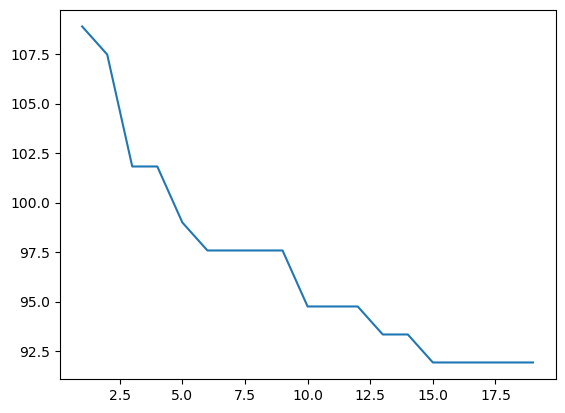

In [28]:
plt.plot(FG.prominence_diagram()[:20])

In [29]:
cluster_labels = FG.persistence_based_flattening(n_clusters=10, flattening_mode='conservative')
clustered_points = (cluster_labels >= 0)

# print adjusted rand index, and percentage of data points clustered
ari = adjusted_rand_score(Y_1[clustered_points], cluster_labels[clustered_points])
pct_clustered = (np.sum(clustered_points) / Y_1.shape[0])
print('adjusted rand index: ' + str(ari))
print('percentage of data points clustered: ' + str(pct_clustered))

adjusted rand index: 1.591106760934534e-05
percentage of data points clustered: 1.0


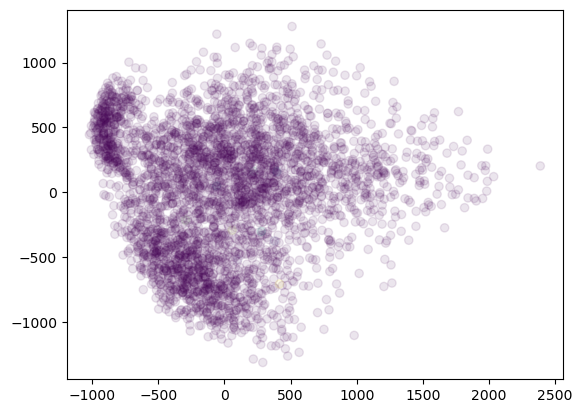

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
proj = pca.fit_transform(X_1)
f,ax = plt.subplots()
ax.scatter(proj[:,0],proj[:,1], c= cluster_labels, alpha=0.1)
plt.show()